In [326]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading data

In [2]:
data_path = 'CrowdstormingDataJuly1st.csv'
raw_data = pd.read_csv(data_path)

In [3]:
raw_data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


# Process data, extract features and labels

Remove entries with both skin tone rating not available

In [4]:
data = raw_data.dropna(how='all', subset=['rater1', 'rater2'])

Extract relevant features and remove NaN values

In [5]:
features = data.loc[:, data.dtypes != object].copy()
features.drop(['rater1', 'rater2'], axis=1, inplace=True)
features.dropna(inplace=True)
features.head()

,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,refNum,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,177.0,72.0,1,0,0,1,0,0,0,0,1,1,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,179.0,82.0,1,0,0,1,0,1,0,0,2,2,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
5,182.0,71.0,1,0,0,1,0,0,0,0,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,187.0,80.0,1,1,0,0,0,0,0,0,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,180.0,68.0,1,0,0,1,0,0,0,0,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752


Extract and create labels for the correspond features

In [6]:
labels = 0.5*(data.rater2 + data.rater1).copy()
labels = labels[features.index]
labels.head()

0    0.375
1    0.750
5    0.125
6    0.125
7    1.000
dtype: float64

# Train a Random Forest Classifier

Convert data to numpy array

In [148]:
y = np.asarray(labels, dtype="|S6")
X = features.as_matrix()
print('dimensions y =', y.shape)
print('dimensions X =', X.shape)

dimensions y = (123715,)
dimensions X = (123715, 18)


Split data into training and testing sets

In [139]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)

Define function to print accuracy of the model

In [140]:
def print_score(classifier, X_train, y_train, X_test, y_test):
    print('Train set score :', classifier.score(X_train, y_train))
    print('Test set score :', classifier.score(X_test, y_test))

Create, train and test the random forest classifier

In [141]:
rfc = RandomForestClassifier(n_jobs=-1)
model = rfc.fit(X_train, y_train)

print_score(rfc, X_train, y_train, X_test, y_test)

Train set score : 0.973990282281
Test set score : 0.51931781442


We clearly see that the model is overfitting. We can decrease the overfitting by increasing the number of maximum features

In [142]:
rfc = RandomForestClassifier(max_features=None, n_jobs=-1)
model = rfc.fit(X_train, y_train)

print_score(rfc, X_train, y_train, X_test, y_test)

Train set score : 0.970828880127
Test set score : 0.673779502102


# TODO
- Try other parameters
- Don't know what "Perform cross-validation to mitigate the overfitting of your model." means
- Maybe add other features such as country or other strings by converting them to a scale (1 to n)

Here is some code scraps :

In [153]:
## ---> Cross validation score <---
#scores = cross_val_score(rfc, X_train, y_train, cv=3)
#scores.mean()

## ---> Parameters search using grid search <---
#parameters = {'n_estimators': [5, 10, 15, 20],
#              'max_depth': [2, 5, 7, 9]}
#grid_rfc = GridSearchCV(rfc, parameters)
#grid_rfc.fit(X_train, y_train, oob_score=True)

## ---> K-fold score <---
#kfold = KFold(n_splits=20)
#kfold_score = [rfc.fit(X_train[train], y_train[train]).score(X_train[test], y_train[test])
#               for train, test in kfold.split(X_train)]
#kfold_score

# Feature imporances

Starting by defining a function to plot the features importances

In [307]:
def plot_features_importances(features_importances):
    ft_imp.plot(kind='bar')
    
    #plt.title('Feature importance for the trained random forest model')
    plt.xlabel('Feature name', fontweight='bold')
    plt.ylabel('Feature importance [%]', fontweight='bold')
    plt.show()

Extract and plot the features importances

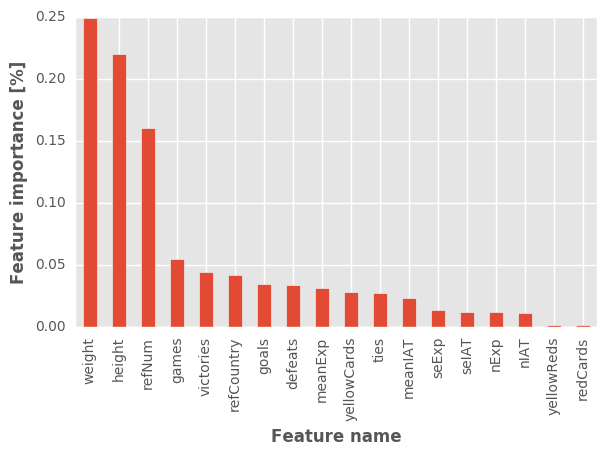

In [316]:
# Extract features importances from model
features_importances = model.feature_importances_

# Create series from features importances and features names
ft_imp = pd.Series(features_importances, index=features.columns.values).sort_values(ascending=False)

# Plot features
plot_features_importances(ft_imp)

Three features stands out : 'height', 'weight' and 'refNum'. We can try to use the first 6 most usefull features to train our random forest classifier

In [312]:
# number of features choosen
n_features = 6

# extract reduced features set and drop NaN values
features_reduced = data[ft_imp.head(n_features).index].copy()
features_reduced.dropna(inplace=True)

# extract and create reduced labels
labels_reduced = labels[features_reduced.index]

# show reduced features
features_reduced.head()

,weight,height,refNum,games,victories,refCountry
0,72.0,177.0,1,1,0,1
1,82.0,179.0,2,1,0,2
5,71.0,182.0,4,1,0,4
6,80.0,187.0,4,1,1,4
7,68.0,180.0,4,1,0,4


We can now train our random forest classifier on the reduced data set

In [315]:
# convert dataframe to numpy array
y_r = np.asarray(labels_reduced, dtype="|S6")
X_r = features_reduced.as_matrix()

# split data into training and testing sets
seed = 42
X_r_train, X_r_test, y_r_train, y_r_test = train_test_split(X_r, y_r, test_size=0.1, random_state=seed)

# create and train model
rfc_r = RandomForestClassifier(max_features=None, n_jobs=-1)
model_r = rfc_r.fit(X_r_train, y_r_train)

# compute score of the train model
print_score(rfc_r, X_r_train, y_r_train, X_r_test, y_r_test)

Train set score : 0.951426700514
Test set score : 0.644143053201


We can see that the model is not really better. Let's see the features importances

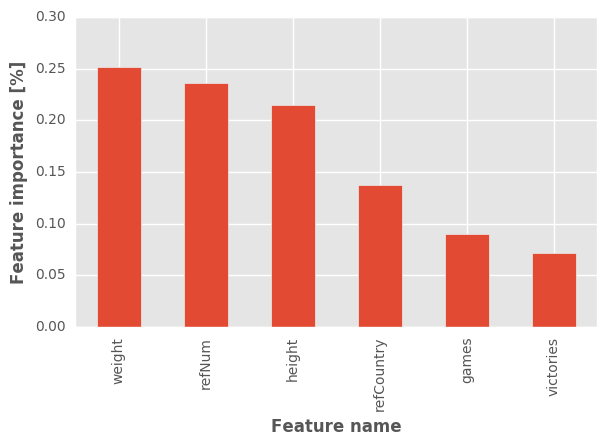

In [317]:
# Extract features importances from model
features_importances_reduced = model_r.feature_importances_

# Create series from features importances and features names
ft_imp = pd.Series(features_importances_reduced, index=features_reduced.columns.values).sort_values(ascending=False)

# Plot features
plot_features_importances(ft_imp)

# Learning curve

Compute score for different values for parameters *n_estimators* and *mas_depth* of the random forest classifier. **Warning this cell is long to run**.

In [350]:
# create starting random forest classifier
rfc_l = RandomForestClassifier(max_features=None, n_jobs=-1)

# create range of parameters and a grid search object
parameters = {'n_estimators': [5, 10, 15, 20],
              'max_depth': [2, 5, 7, 9]}
grid_rfc = GridSearchCV(rfc_l, parameters)

# train classifier with all parameters
model_grid = grid_rfc.fit(X_train, y_train)

In [352]:
model_grid.cv_results_

{'mean_fit_time': array([ 0.24426587,  0.43901189,  0.54590464,  0.74967726,  0.47026237,
         0.94131263,  1.18035388,  1.38037388,  0.53570024,  0.94705327,
         1.3424685 ,  1.75222834,  0.63553452,  1.04311283,  1.5792888 ,
         2.04636367]),
 'mean_score_time': array([ 0.1244301 ,  0.12815658,  0.12162415,  0.13972378,  0.12241562,
         0.12147991,  0.12413446,  0.13553635,  0.12614783,  0.13072411,
         0.12992636,  0.13387648,  0.12564731,  0.13069121,  0.13161381,
         0.14114189]),
 'mean_test_score': array([ 0.33085151,  0.33389616,  0.333016  ,  0.32956719,  0.37521892,
         0.37829949,  0.37658407,  0.37753608,  0.40791069,  0.4102548 ,
         0.41100024,  0.41297612,  0.47063578,  0.48025471,  0.47807226,
         0.47923085]),
 'mean_train_score': array([ 0.33225254,  0.33461919,  0.3339949 ,  0.33070777,  0.37641344,
         0.37948502,  0.37827257,  0.37874401,  0.4106859 ,  0.41308842,
         0.41455678,  0.41596237,  0.47858879,  0.489